In [102]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, cv2, os, random

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import EfficientNetB0

In [103]:
train_dataset = 'dataset/training/' 
test_dataset = 'dataset/testing/'

We now need to preprocess images within each folder and label them according to their classification.

In [253]:
image_size_x, image_size_y = 150, 150

def preprocess_image(img_path):
    # read in the image
    if type(img_path) == np.ndarray:
        img = img_path
    else:
        img = cv2.imread(img_path)
        
    # convert image to grayscale
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # normalize the image array
    # img = img / 255

    # resize the image for uniformity
    img = cv2.resize(img, (image_size_x, image_size_y))

    return img

In [105]:
def rotate_image(image, angle):
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

In [204]:
encode = {'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}
decode = {0: 'no_tumor', 1: 'meningioma_tumor', 2: 'glioma_tumor', 3: 'pituitary_tumor'}

def load_data(dataset_path):
    x_data = [] # images
    y_data = [] # labels

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        # check if the path is a directory and skip if not
        if not os.path.isdir(folder_path):
            continue  
        
        for file in os.listdir(folder_path):
            # find path of the image
            file_path = os.path.join(folder_path, file)

            # preprocess the image
            img = preprocess_image(file_path)

            # append the new image to the x array
            x_data.append(img)

            # append the label to the y array
            y_data.append(encode[folder])
            
            # apply rotation on image
            # img = rotate_image(img, random.randint(-45,45))
            
            # append new data to the arrays
            # x_data.append(img)
            # y_data.append(encode[folder])
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # shuffle data for better training
    x_data, y_data = shuffle(x_data, y_data, random_state=83)
    
    return x_data, y_data


In [205]:
x_train, y_train = load_data(train_dataset)
x_test, y_test = load_data(test_dataset)

In [206]:
print(y_train.shape)

(2870,)


Let us take a look at some images within our dataset.

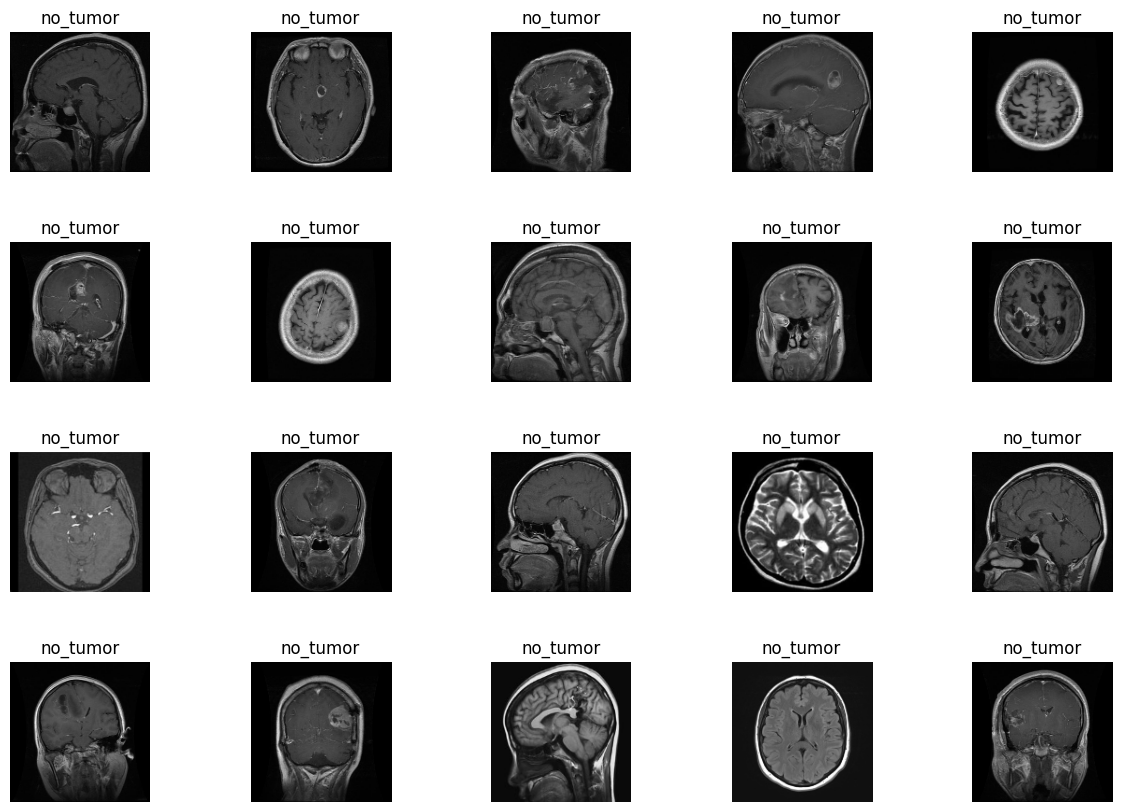

In [259]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.ravel()
for i in range(0, 20):
    index = random.randint(0, len(x_train))
    axes[i].imshow(x_train[index], cmap='gray')
    axes[i].set_title(decode[np.argmax(y_train[index])])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

Now with our data we can create our model.

In [221]:
efficient_net = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size_x, image_size_y, 3))

In [222]:
num_classes = len(np.unique(y_train))

def build_model(num_classes):
    model = efficient_net.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    model = tf.keras.layers.Dense(num_classes, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=efficient_net.input, outputs=model)

    model.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam', metrics= ['accuracy'])
    
    return model

In [223]:
def train_model(model, x_train, y_train, x_test, y_test, batch_size=0, epochs=10):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
    return history

In [224]:
model = build_model(num_classes=num_classes)
history = train_model(model, x_train, y_train, x_test, y_test, batch_size=16, epochs=8)

Epoch 1/8
180/180 [==============================] - 79s 411ms/step - loss: 0.4694 - accuracy: 0.8289 - val_loss: 2.5258 - val_accuracy: 0.6497
Epoch 2/8
180/180 [==============================] - 75s 414ms/step - loss: 0.2181 - accuracy: 0.9268 - val_loss: 1.3222 - val_accuracy: 0.7335
Epoch 3/8
180/180 [==============================] - 73s 404ms/step - loss: 0.1424 - accuracy: 0.9516 - val_loss: 1.4941 - val_accuracy: 0.6878
Epoch 4/8
180/180 [==============================] - 73s 405ms/step - loss: 0.1067 - accuracy: 0.9655 - val_loss: 2.0353 - val_accuracy: 0.7208
Epoch 5/8
180/180 [==============================] - 76s 422ms/step - loss: 0.0800 - accuracy: 0.9746 - val_loss: 1.3854 - val_accuracy: 0.7843
Epoch 6/8
180/180 [==============================] - 73s 407ms/step - loss: 0.1146 - accuracy: 0.9627 - val_loss: 1.0412 - val_accuracy: 0.7716
Epoch 7/8
180/180 [==============================] - 74s 412ms/step - loss: 0.0865 - accuracy: 0.9735 - val_loss: 1.3294 - val_accuracy:

With this working model, we can evaluate the model and make our observations via the following metrics.

In [225]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.title('Neural Network Accuracy')
    plt.show()

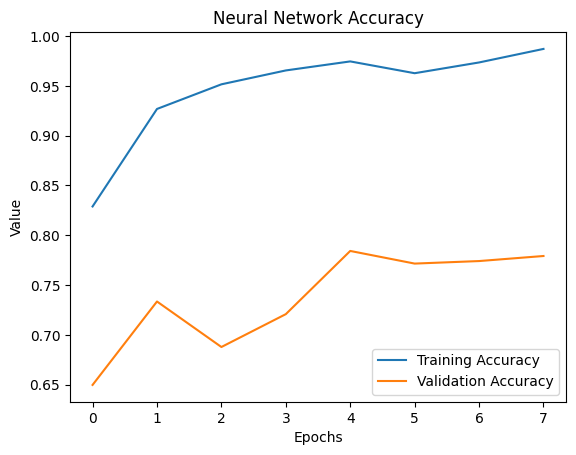

In [226]:
plot_accuracy(history)

In [227]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('Neural Network Loss')
    plt.show()

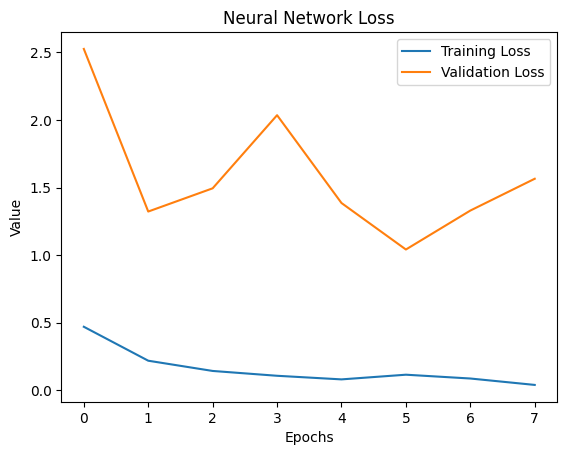

In [228]:
plot_loss(history)

In [239]:
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encode.keys())
    display.plot()

13/13 [==============================] - 3s 171ms/step


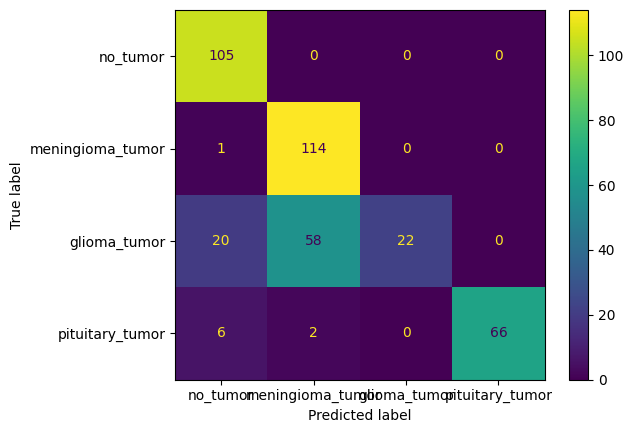

In [240]:
plot_confusion_matrix(model, x_test, y_test)

Finally, we can use our model to make predictions on images outside of our dataset with the following function.

In [241]:
# make a prediction function
def predict_image(model, img):
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    prediction = np.argmax(prediction)
    return decode[prediction]

1/1 [==============================] - 0s 22ms/step


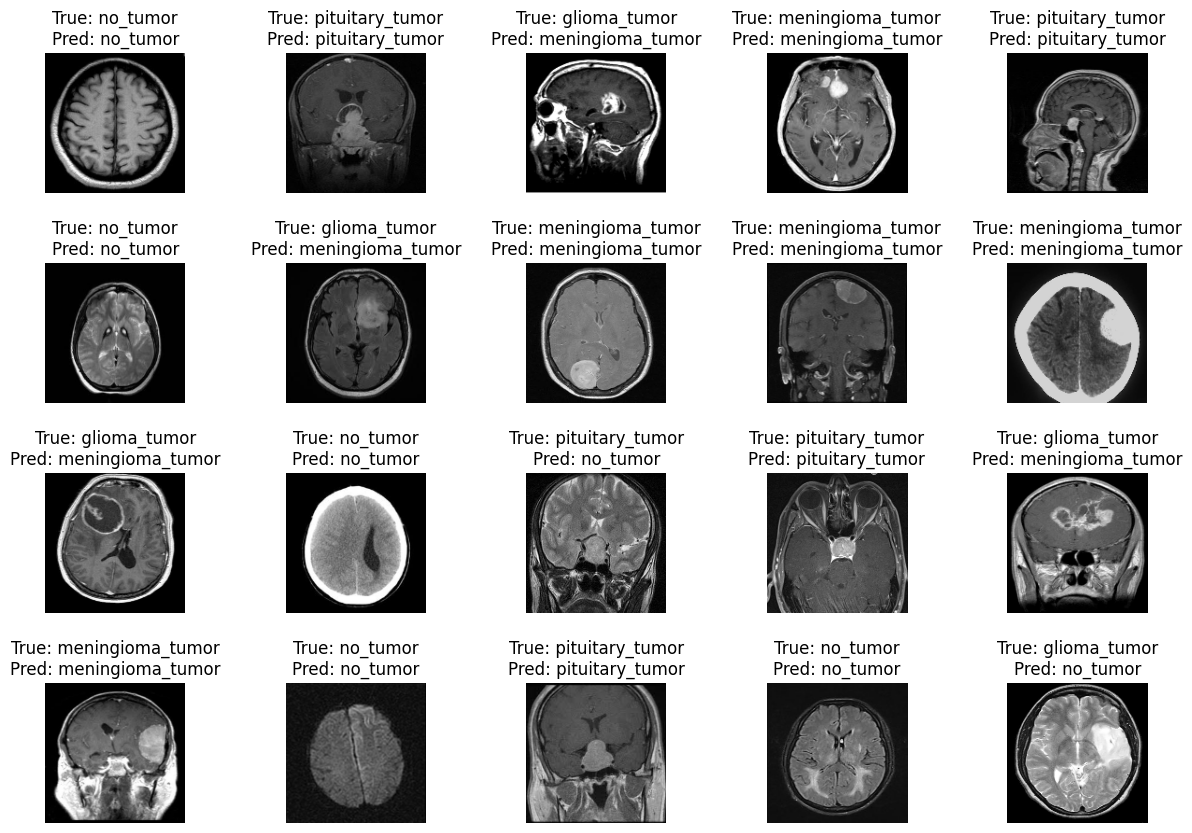

In [258]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.ravel()
for i in range(0, 20):
    index = random.randint(0, len(x_test))
    axes[i].imshow(x_test[index], cmap='gray')
    axes[i].set_title(f'True: {decode[y_test[index]]}\nPred: {predict_image(model, x_test[index])}')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()